# Variational Autoencoder

![VAE](notebook_images/vae.jpg)

Variational AE are similar to vanilla autoencoder, but the latent space is sampled from a normal distribution $N(\mu, \sigma)$. Besides regularizing the latent space, it commonly produces better results.

**Original paper:**

Auto-Encoding Variational Bayes, Diederik P Kingma, Max Welling - Auto-Encoding Variational Bayes - https://arxiv.org/abs/1312.6114

**Further reading:**

Understanding Variational Autoencoders (VAEs) - https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [2]:
print(torch.__version__)

2.2.1+cu118


# Aux functions for display purposes

In [3]:
from matplotlib import colors

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


def show_preds(set1, set2, count):
  
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(count, 2 * rows))
  
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(np.transpose(set1[n].numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(np.transpose(set2[n].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')      

## Configuration

In [4]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


### Load and prepare MNIST dataset

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor()]) #, transforms.RandomHorizontalFlip(1.0)])

train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

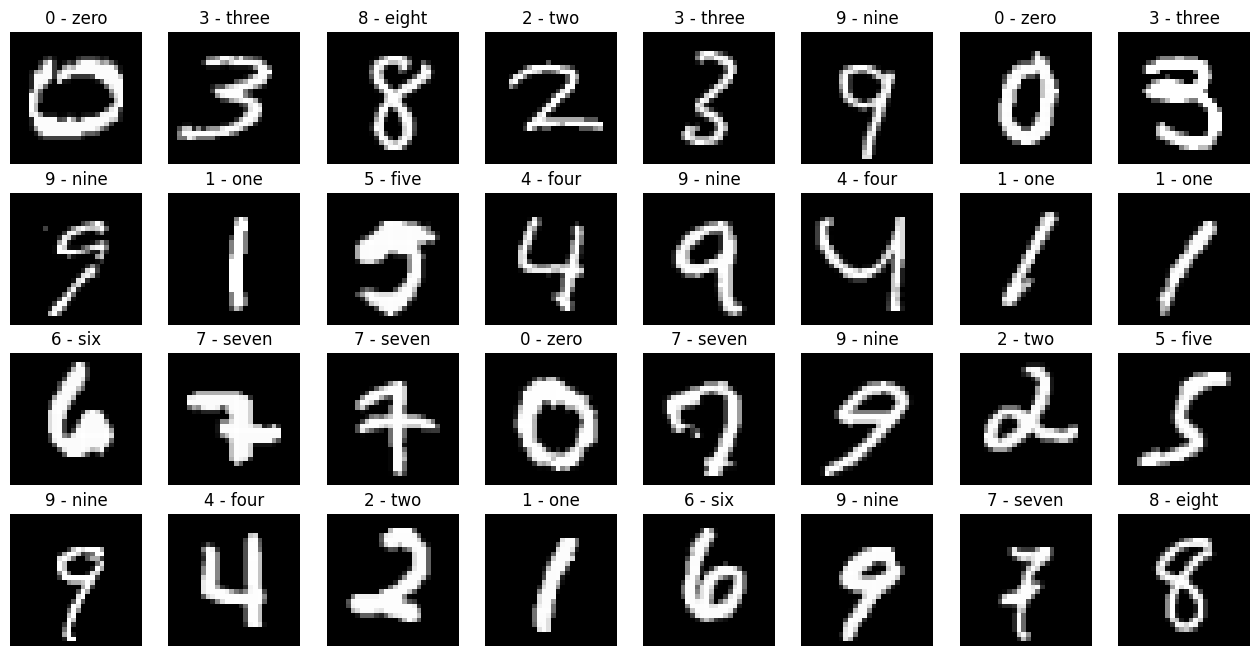

<Figure size 640x480 with 0 Axes>

In [6]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, train_set.classes) 

## Architecture

We are modelling a class for the encoder, and another for the decoder. These two classes will be the main building blocks of the autoencoder class, together with the sampling procedure.

In [7]:
class Encoder(torch.nn.Module):

    def __init__(self, latent_space_dim):

        super().__init__()

        # encoder layers
        self.econv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size= 3, stride = 2)
        self.erelu1 = torch.nn.ReLU()
        self.ebn1 = torch.nn.BatchNorm2d(32)

        self.econv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 3, stride = 2)
        self.erelu2 = torch.nn.ReLU()
        self.ebn2 = torch.nn.BatchNorm2d(64)

        self.efc1_mean = torch.nn.Linear(3136, latent_space_dim)
        self.efc1_log_var = torch.nn.Linear(3136, latent_space_dim)

    def forward(self, x):

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv1(x)
        x = self.ebn1(x)
        x = self.erelu1(x)

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv2(x)
        x = self.ebn2(x)
        x = self.erelu2(x)

        x = torch.flatten(x,1)
        mean = self.efc1_mean(x)
        log_var = self.efc1_log_var(x)

        return mean, log_var


In [8]:
class Decoder(torch.nn.Module):

    def __init__(self, latent_space_dim):
        
        super().__init__()

        self.dfc1 = torch.nn.Linear(latent_space_dim, 3136)
        
        self.dconvT1 = torch.nn.ConvTranspose2d(64, 32, 3, 2, padding = 1, output_padding=1)
        self.drelu1 = torch.nn.ReLU()
        self.dbn1 = torch.nn.BatchNorm2d(32)

        self.dconvT2 = torch.nn.ConvTranspose2d(32, 1,3,2, padding = 1, output_padding = 1)
        self.dsig = torch.nn.Sigmoid()


    def forward(self, x):

        x = self.dfc1(x)
        x = x.reshape(-1, 64, 7, 7)
        x = self.dconvT1(x)
        x = self.dbn1(x)
        x = self.drelu1(x)

        x = self.dconvT2(x)
        x = self.dsig(x)

        return x        

### Sampling Layer

The output of the encoder is $\hspace{0.5cm}$ $\mu$ (mean), $\log(\sigma^2)$ (logvar)

This will be the input of the encoder.

Note: log var can assume any value, whereas variances are by definition positive. Since the outupt of a unit is not necessarily unbounded, the log var ensures that var is positive.




Consider: $\hspace{0.5cm}$ $\epsilon  \thicksim N(0,1)$

Sampling from a normal distribution $N(\mu, \sigma^2)$: $\hspace{0.5cm}$ $z = \mu + \sigma \times \epsilon$

However, we don't have $\sigma$, we have $\log(\sigma^2)$

$z = \mu + \sigma \times \epsilon = \mu + \exp(log(\sigma)) \times \epsilon= \mu + \exp(0.5 \times (\log(\sigma)+log(\sigma))) \times \epsilon  $

Output:  $\hspace{0.5cm}$ $z = \mu + \exp(0.5 \times \log(\sigma^2)) \times \epsilon$




In [9]:
class VAE(torch.nn.Module):

    def __init__(self, encoder, decoder):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def reparametrization(self, mean, var):

        epsilon = torch.randn_like(mean).to(device)    
        z = mean + var * epsilon  
        return z  

    def forward(self, x):

        mean, log_var = self.encoder(x)
        var = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, var)
        output = self.decoder(z)

        return output, mean, log_var

In [10]:
encoder = Encoder(LATENT_SPACE_DIM)
decoder = Decoder(LATENT_SPACE_DIM)

model = VAE(encoder=encoder, decoder=decoder).to(device)
model.to(device)

torchinfo.summary(model, input_size=(BATCH_SIZE, 1, 28, 28), col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"])



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
VAE                                      --                        [32, 1, 28, 28]           [32, 1, 28, 28]           --                        --
├─Encoder: 1-1                           --                        [32, 1, 28, 28]           [32, 2]                   --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [32, 1, 29, 29]           [32, 32, 14, 14]          320                       2,007,040
│    └─BatchNorm2d: 2-2                  --                        [32, 32, 14, 14]          [32, 32, 14, 14]          64                        2,048
│    └─ReLU: 2-3                         --                        [32, 32, 14, 14]          [32, 32, 14, 14]          --                        --
│    └─Conv2d: 2-4                       [3, 3]                    [32, 32, 15, 15]          [3

## Loss function

The loss function has two components: 

- **reconstruction loss** - this is similar to an normal autoencoder. This term measures the discrepancy between the obtained output and the desired output, and its purpose is to obtain a more faithful reconstruction
- **KL loss**: this is the Kullback-Leibler (KL) divergence between the learned distribution of the latent variables and a known prior distribution (typically a standard normal distribution). The goal is to obtain a distribution as close as possible to the prior distribution, thereby ensuring that the latent space can be better explored. 

reconstruction loss = $1/N \sum (train_x - output)^2$

For the KL Loss we are considering the prior to be a Normal distribution with $\mu = 0$ and $\sigma = 1$

KL loss = $1/N \sum - 0.5 \times log(\sigma^2) - \mu^2 - e^{log(\sigma^2)}$

loss = reconstruction loss + KL loss

In [11]:
BCE_loss = torch.nn.BCELoss(reduction = 'sum')

def loss_function(x, output, mean, log_var):
    reproduction_loss = BCE_loss(output, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = torch.optim.Adam(model.parameters())

## Training

In [12]:
TRAIN_ONLINE = False

if TRAIN_ONLINE:

    EPOCHS = 10

    print("Start training VAE...")
    model.train()

    for epoch in range(EPOCHS):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):

            x = x.to(device)

            optimizer.zero_grad()

            output, mean, log_var = model(x)
            loss = loss_function(x, output, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*BATCH_SIZE))
        
    print("Finish!!")

    torch.save({
                    'epoch': epoch,
                    'model':model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    },
                    f'vae_{LATENT_SPACE_DIM}_best.pt')

else:

    LATENT_SPACE_DIM = 2
    reload = torch.load(f'vae_{LATENT_SPACE_DIM}_best.pt')
    print(reload['epoch'])
    model = VAE(Encoder(LATENT_SPACE_DIM), Decoder(LATENT_SPACE_DIM))
    model.to(device)
    model.load_state_dict(reload['model'])

Start training VAE...


	Epoch 1 complete! 	Average Loss:  187.57165140581486
	Epoch 2 complete! 	Average Loss:  166.6376044274394
	Epoch 3 complete! 	Average Loss:  163.5400012167948
	Epoch 4 complete! 	Average Loss:  161.60602047654584
	Epoch 5 complete! 	Average Loss:  160.4205368351402
	Epoch 6 complete! 	Average Loss:  159.6390153524588
	Epoch 7 complete! 	Average Loss:  158.93237557100767
	Epoch 8 complete! 	Average Loss:  158.42205253609217
	Epoch 9 complete! 	Average Loss:  157.95218970299786
	Epoch 10 complete! 	Average Loss:  157.6160113437453
Finish!!


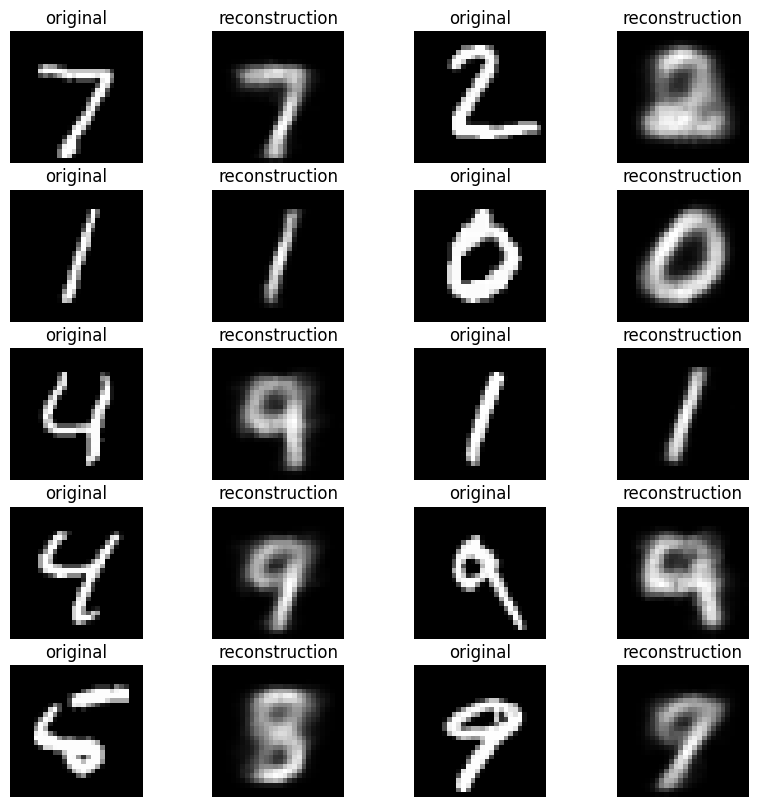

In [21]:
i, _ = next(iter(test_loader))
recon,_,_ = model(i.to(device))
    
show_preds(i, recon, 10)

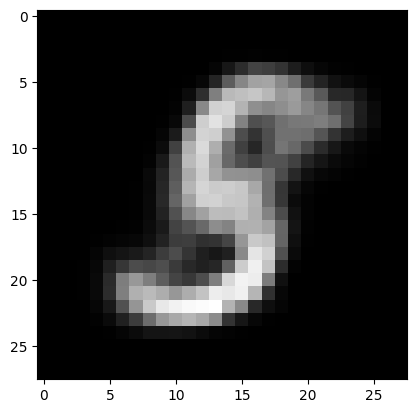

In [22]:
if LATENT_SPACE_DIM == 2:
    pred = model.decoder(torch.randn(LATENT_SPACE_DIM).to(device))
    plt.imshow(np.transpose(pred[0].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)

Displaying Latent Space

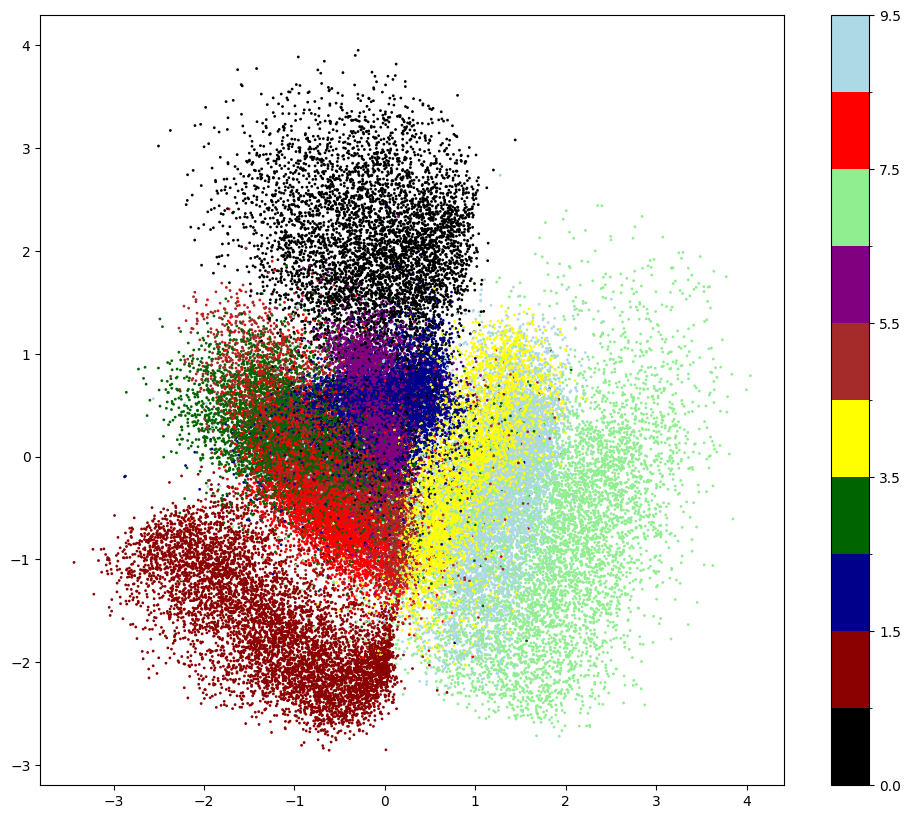

In [ ]:
if LATENT_SPACE_DIM == 2:

    encoded_mean = []
    encoded_log_var = []
    targets = []
    for i,t in train_loader:
        mean, log_var = model.encoder(i.to(device))
        encoded_mean.extend(mean.cpu().detach().numpy())  
        encoded_log_var.extend(log_var.cpu().detach().numpy())
        targets.extend(t)

    x = [m[0] for m in encoded_mean]
    y = [m[1] for m in encoded_mean]

    plot_scatter(x,y,targets)

The percentage of values that lie within an interval estimate in a normal distribution: 68%, 95%, and 99.7% of the values lie within one, two, and three standard deviations of the mean, respectively.

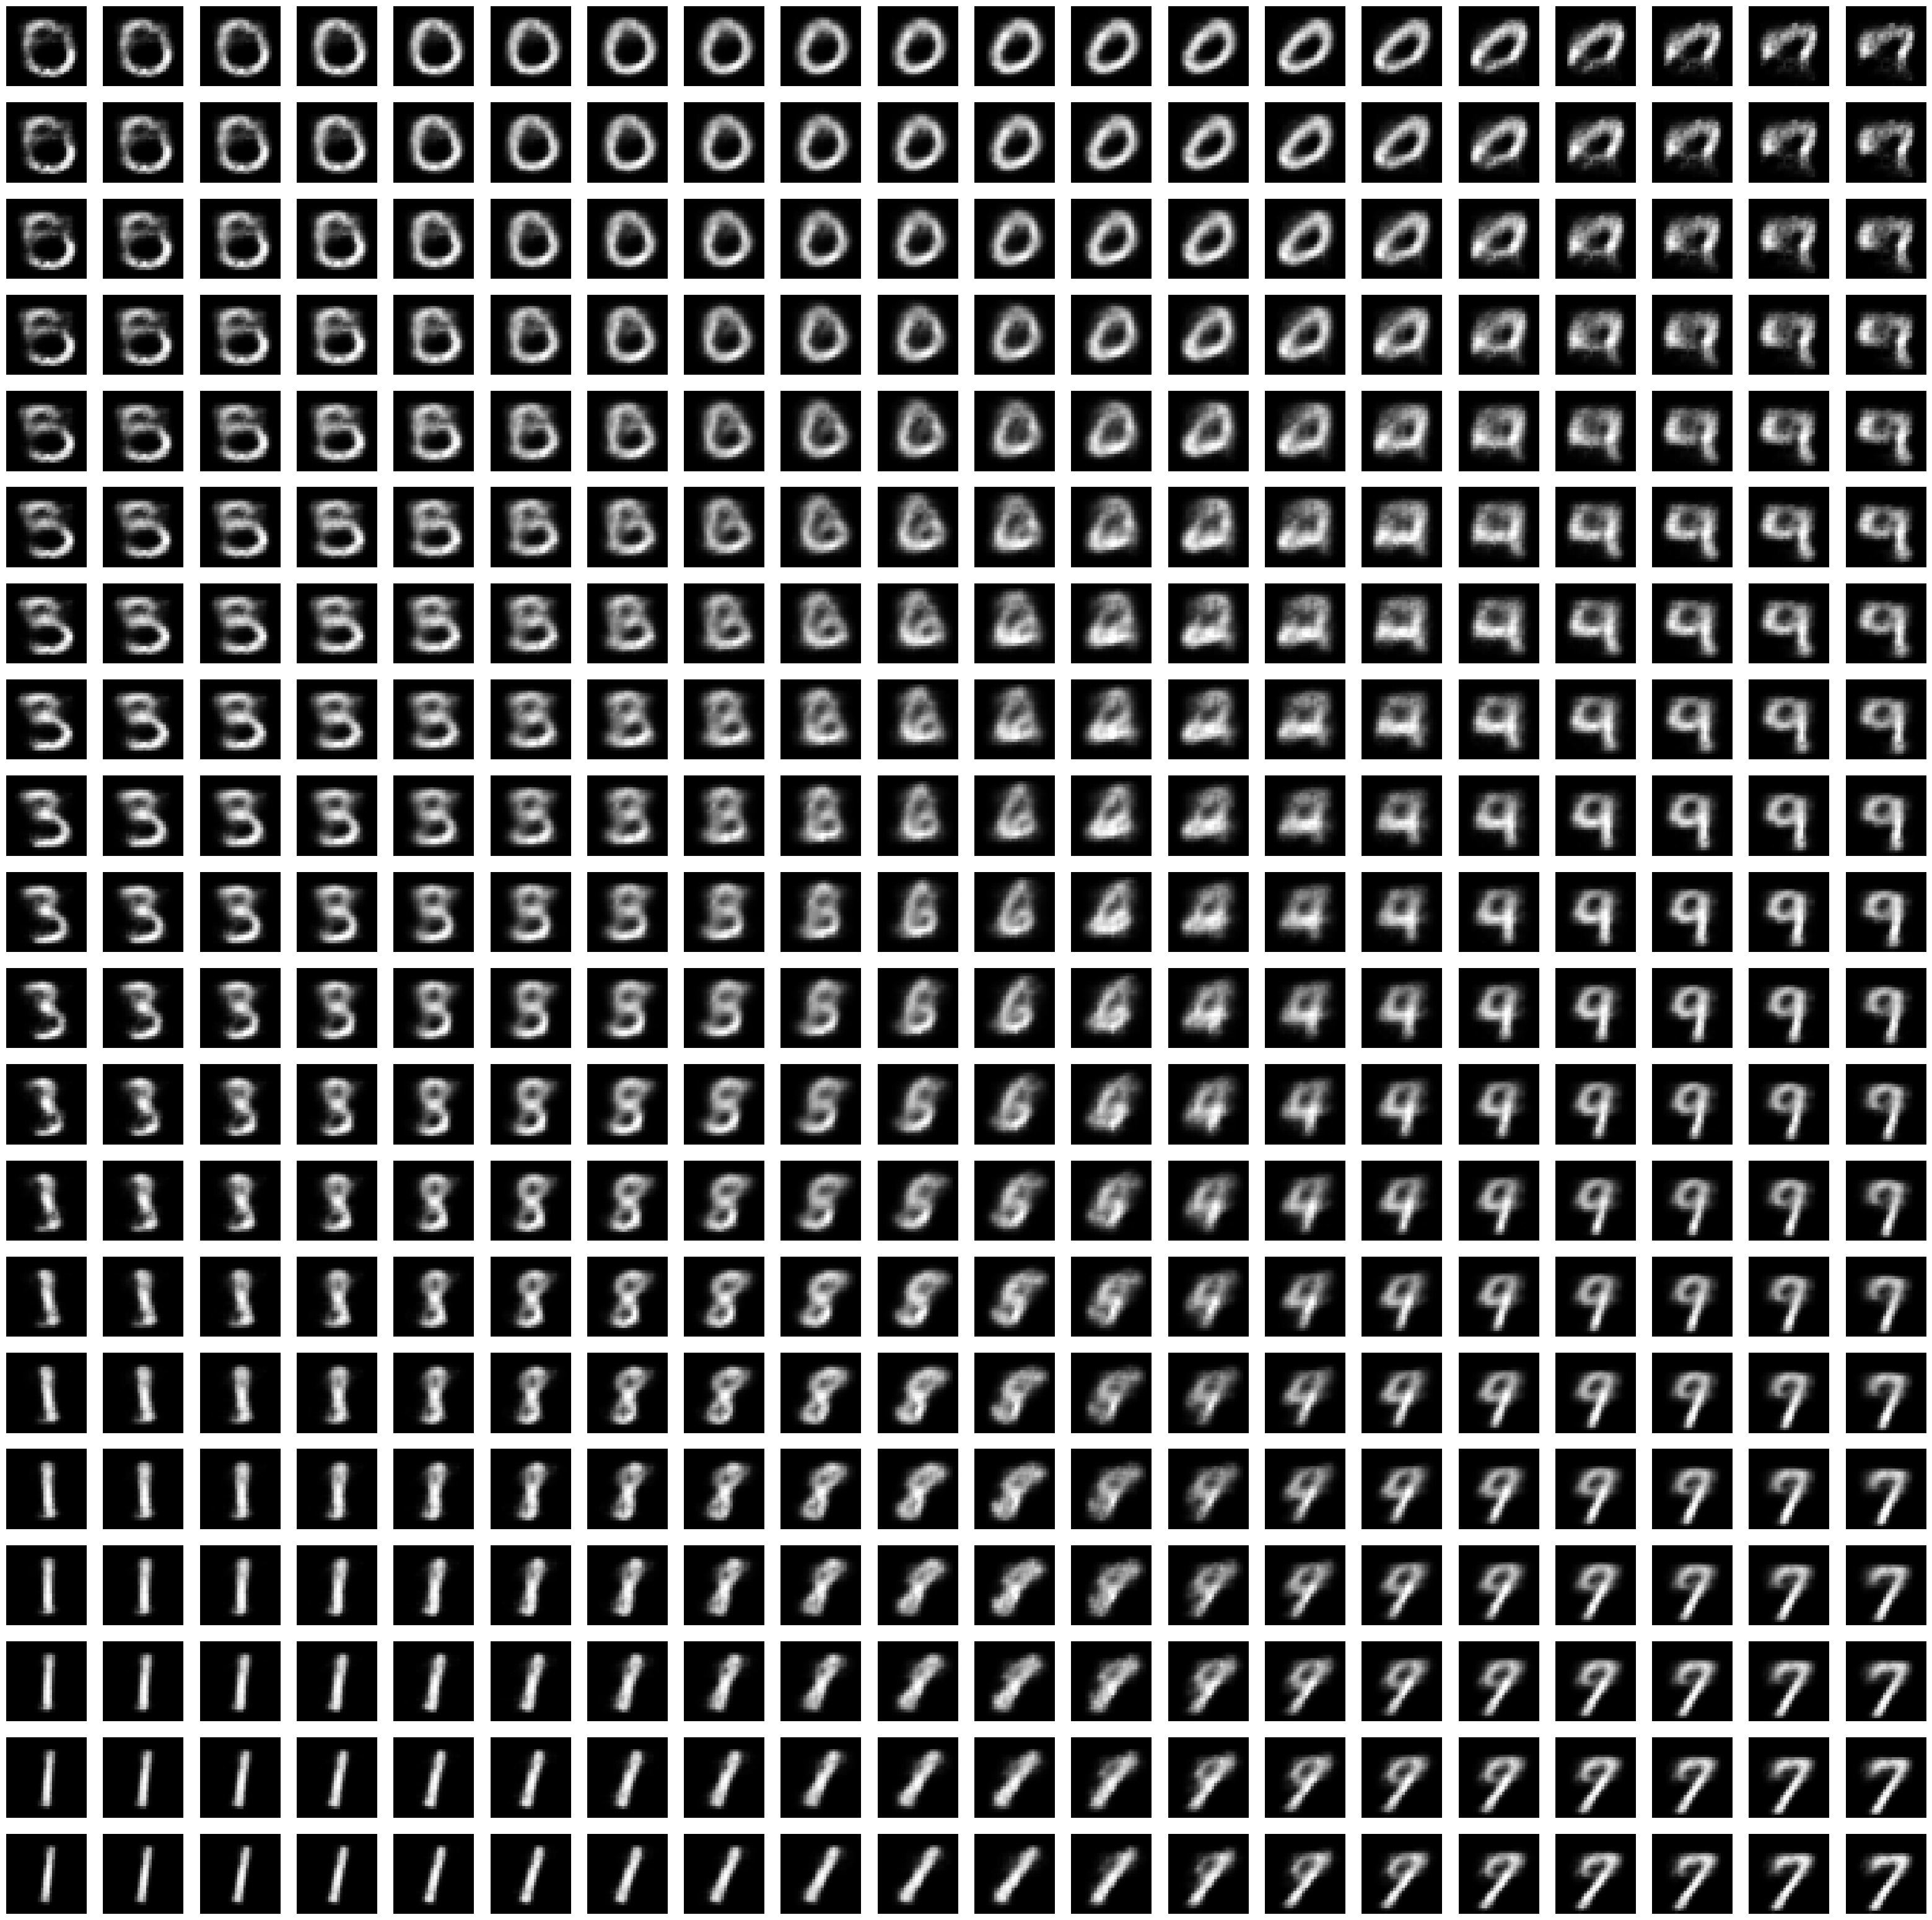

<Figure size 640x480 with 0 Axes>

In [ ]:
if LATENT_SPACE_DIM == 2:
    limit = 2
    steps = 20

    step = (2.0 * limit) / steps

    vector_generation = [[-limit + j*step, limit - i*step] 
                                for i in range(steps) for j in range(steps)]

    predictions = model.decoder(torch.Tensor(vector_generation).to(device))

    vcpi_util.show_predicted_images(steps, steps, predictions.cpu().detach(), 10)